In [1]:
import os
os.chdir("../")
print("Moved up")

Moved up


In [2]:
import importlib
import copy
import pickle
import typing as tp
from functools import partial

import jax
import jax.numpy as jnp
import jax.flatten_util as fu
from flax import linen as nn  # Linen API
import numpy as np
import matplotlib.pyplot as plt
import optax
import math

from tqdm import tqdm
import time

import lib_data
import utils
import modules
import callbacks

%env XLA_PYTHON_CLIENT_MEM_FRACTION=.9
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print("devices", jax.devices())

shade_colours = plt.get_cmap('Set3')
dark_colours = plt.get_cmap('tab10')
all_colours = plt.get_cmap('tab20')

def light_colours(i):
    return all_colours(2*i+1)

2025-02-10 11:58:05.992264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739188686.006261   69295 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739188686.010486   69295 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


env: XLA_PYTHON_CLIENT_MEM_FRACTION=.9
devices [CudaDevice(id=0)]


# Dataset

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


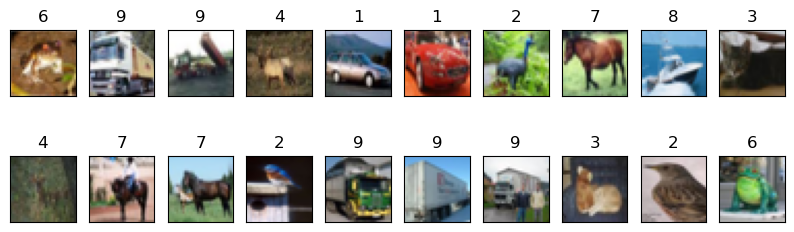

3


In [3]:
#-----------------------------------------------------------------------------------------------------------------------------
n_out = 10

n_train: int = 512 * n_out
n_eval: int = 200 * n_out
n_hess: int = 512 * n_out
use_mse = False

importlib.reload(lib_data)
def __get_datasets():
    datasets = lib_data.get_cifar10(flatten=False, tr_indices=n_train, te_indices=n_eval, hess_indices=n_hess,
                            tr_classes=n_out, te_classes=n_out, hess_classes=n_out, one_hot = use_mse, 
                              augmentations = False, visualise=True)

    data_name = "cifar10_"+str(n_out)+"cl_"+str(n_train) + "_" + str(n_eval) 
    print(len(datasets))
    return datasets, data_name

datasets, data_name = __get_datasets()

# Architecture

In [4]:
#-----------------------------------------------------------------------------------------------------------------------------
importlib.reload(modules)

class ResBlock(nn.Module):
    out_channels: int
    strides: int = 1
    depth: int = 2
    p_drop: float = 0.1
    dropout: bool = True
    bn: bool = True
    sc_conv: str = "Identity"
    default_kernel_init: tp.Callable = nn.initializers.lecun_normal()

    @nn.compact
    def __call__(self, x, train: bool = True):
        # Shortcut connection
        sc = x
        if self.strides > 1:
            if "Iden" in self.sc_conv:
                # Identity shortcut with strided subsampling
                sc = jnp.pad(
                    x[:, ::self.strides, ::self.strides, :],
                    pad_width=((0, 0), (0, 0), (0, 0),
                               ((self.out_channels - x.shape[-1]) // 2,
                                self.out_channels - x.shape[-1] - (self.out_channels - x.shape[-1]) // 2)),
                    mode="constant"
                )
            elif "Conv" in self.sc_conv:
                sc = nn.Conv(self.out_channels, kernel_size=(1, 1), strides=self.strides, use_bias=False,
                             kernel_init=self.default_kernel_init)(sc)
                if self.bn:
                    sc = nn.BatchNorm(use_running_average=not train)(sc)
            elif "Line" in self.sc_conv:
                sc = sc[:, ::self.strides, ::self.strides, :]
                sc = nn.Dense(self.out_channels)(sc)

        # Main block layers
        for i in range(self.depth):
            x = nn.Conv(self.out_channels, kernel_size=(3, 3), strides=(self.strides if i == 0 else 1),
                        use_bias=False, kernel_init=self.default_kernel_init)(x)
            if self.bn:
                x = nn.BatchNorm(use_running_average=not train)(x)
            if self.dropout:
                x = nn.Dropout(self.p_drop)(x, deterministic=not train)
            x = nn.relu(x)  # Activation

        # Residual connection
        x = nn.relu(x + sc)
        return x



class ResNet(nn.Module):
    """A ResNet20 model."""
    n_blocks: int = 3
    layers_per_block: int = 3
    depth_per_layer: int = 2
    base_width: int = 8
    width_expansion_factor: int = 2
    
    use_DO: bool = False
    use_BN: bool = True
    sc_conv: tp.Any = 'Identity'
    deterministic: tp.Optional[bool] = None

    @nn.compact
    def __call__(self, x, train=True):
        # deterministic = not train
        # deterministic = nn.merge_param('deterministic', self.deterministic, deterministic)
        x = nn.Conv(self.base_width, [3, 3], strides=[1, 1], use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not train)(x) if self.use_BN else modules.Lambda(f=lambda x: x)(x)
        x = nn.Dropout(0.1)(x, deterministic=not train) if self.use_DO else modules.Lambda(f=lambda x: x)(x)
        x = modules.Lambda(jax.nn.relu)(x)

        for i in range(self.n_blocks):
            width_factor = self.width_expansion_factor**i
            for j in range(self.layers_per_block):
                strides = 2 if (i>0 and j==0) else 1
                x = ResBlock(out_channels=width_factor*self.base_width, strides=strides, depth=self.depth_per_layer,
                             dropout=self.use_DO, bn=self.use_BN, sc_conv=self.sc_conv)(x, train)  # 3
        
        x = partial(jnp.mean, axis=(1, 2))(x)
        x = nn.Dense(10)(x)

        return x


In [5]:
def __get_arch__():
    n_blocks = 3
    layers_per_block = 3
    depth_per_layer = 2
    base_width = 8
    use_DO = False
    use_BN = True
    sc_conv = "Identity"

    depth_name = str(int(2+n_blocks*layers_per_block*depth_per_layer))
    model = ResNet(n_blocks, layers_per_block, depth_per_layer, use_DO=use_DO, use_BN=use_BN, sc_conv=sc_conv)
    model_name = f"ResNet{depth_name}_base{base_width:d}_{sc_conv}"
    if use_DO:
        model_name += "_DO"
    if use_BN:
        model_name += "_BN"
    return model, model_name
    
model_arch, model_name = __get_arch__()
print(model_name)

ResNet20_base8_Identity_BN


# Optimizer

In [6]:
#-----------------------------------------------------------------------------------------------------------------------------
importlib.reload(modules)
from optax import contrib

def __get_optim__(warmup_steps, lr, b1, b2, b3, option="", rho=None, sync_period=1):
    # warmup_steps, lr, b1, b2, b3 = hyps['warmup_steps'], hyps['lr'], hyps['b1'], hyps['b2'], hyps['b3']
    if option == 'sam':
        assert rho is not None
        warmup_scheduler = optax.linear_schedule(init_value=0.0, end_value=lr,
                                                transition_steps=warmup_steps,
                                                transition_begin=0,)
        constant_scheduler = optax.constant_schedule(lr)
        lr_scheduler = optax.join_schedules([warmup_scheduler, constant_scheduler], boundaries=[warmup_steps])
        base_opt = modules.get_sgd_optimizer(lr_scheduler, b1, b2, b3, verbose=False)
        adv_opt = modules.get_sgd_optimizer(rho, b1, b2, b3, verbose=False)
        optimizer = contrib.sam(base_opt, adv_opt, sync_period=sync_period, opaque_mode=True) # sam opt
        optim_name = f"sgdFam-SAM_1b{b1}_2b{b2}_3b{b3}_lr{lr}_warmup{warmup_steps}_rho{rho}_syncT{sync_period}"

    else:
        warmup_scheduler = optax.linear_schedule(init_value=0.0, end_value=lr,
                                                transition_steps=warmup_steps,
                                                transition_begin=0,)
        constant_scheduler = optax.constant_schedule(lr)
        lr_scheduler = optax.join_schedules([warmup_scheduler, constant_scheduler], boundaries=[warmup_steps])
        optimizer = modules.get_sgd_optimizer(lr_scheduler, b1, b2, b3, verbose=False)
        optim_name = f"sgdFam_1b{b1}_2b{b2}_3b{b3}_lr{lr}_warmup{warmup_steps}"
        
    return optimizer, optim_name

optimizer, optim_name = __get_optim__(2, 0.1, 0, 0, 0)

# Model Params (Fixed and Tuned)

In [13]:
#-----------------------------------------------------------------------------------------------------------------------------
import itertools
### FIXED
warmup_steps = 2
bs = 64
eval_bs = 2000
n_epochs = 1000
loss_fn = optax.softmax_cross_entropy_with_integer_labels

# FLEXIBLE
# lr = 0.005
# beta_list = [(0., 0., 0.), (0., 0.99, 0.)]
# optim_hp = LR, B1, B2, B3, SAM, Rho, sync_period
optim_hp_list = [
    (0.1, 0., 0., 0., False, 0., 1), 
    (0.1, 0., 0., 0., True, 0.1, 1), 
    (5e-3, 0.9, 0.99, 0., False, 0., 1), 
    (5e-3, 0.9, 0.99, 0., True, 0., 1), 
    (5e-3, 0.9, 0.99, 0., True, 0.001, 1), 
    (5e-3, 0.9, 0.99, -1.0, False, 0., 1), 
    (5e-3, 0.9, 0.99, -1.0, True, 0.001, 1), 
    (5e-3, 0.9, 0.99, -0.5, False, 0., 1), 
    (5e-3, 0.9, 0.99, -0.1, False, 0., 1), 
    (5e-3, 0.9, 0.99, -0.05, False, 0., 1),
    (5e-3, 0.9, 0.99, -0.01, False, 0., 1),
    (5e-3, 0.9, 0.99, -0.005, False, 0., 1), 
    (5e-3, 0.9, 0.99, -0.001, False, 0., 1), 
]
seed_list = [x for x in range(1)]
# sam_list = [False, True]
s = [optim_hp_list, seed_list]
hyp_list = list(itertools.product(*s))
print(len(hyp_list))

13


# Callbacks

In [8]:
#-----------------------------------------------------------------------------------------------------------------------------
sws = 5
cb_freq = 1
hess_freq = int(1e8) # really large
importlib.reload(callbacks)
def __get_cbs__(state, compute_hessian=False):
    cbs = []
    cbs.append(callbacks.saveWeightsCB(sws, grad=True))
    # cbs.append(callbacks.thinCB(thin_freq=cb_freq))

    if compute_hessian:
        hvpCB = callbacks.hvpCB(loss_fn=loss_fn, batches=(datasets[2].data[:n_hess], datasets[2].targets[:n_hess]), 
                            save_freq=hess_freq, hess_bs=n_hess, state=state)
        cbs.append(hvpCB)   
        specCB = callbacks.spectrumCB(n_eigs=20, n_evecs=10, 
                    loss_fn=loss_fn, seed=seed, hvpCB=hvpCB, save_freq=hess_freq, verbose=False)
        cbs.append(specCB)

    esCB = callbacks.earlyStopCB(acc_threshold=0.999, cbs=None, min_eps=sws, max_eps=n_epochs, final_cbs=[hvpCB, specCB],
                                 verbose=False, low_eps=max(sws, 100), low_thresh=0.11)
    cbs.append(esCB)
    return cbs
    


# Train State

In [10]:
from flax import struct                # Flax dataclasses
from clu import metrics
from flax.training import train_state  # Useful dataclass to keep train state
importlib.reload(modules)

@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
    metrics: Metrics
    batch_stats: tp.Any

class TrainStateSAM(modules.TrainStateSAM):
    metrics: Metrics
    batch_stats: tp.Any

def create_train_state(model, optimizer, inputs, rng, option=""):
    """Creates an initial `TrainState`."""
    if option == "":
        params = model.init(rng, jnp.ones_like(inputs[0][jnp.newaxis, :]))['params'] # initialize parameters by passing a template image
        
        tx = optimizer
        return TrainState.create(
          apply_fn=model.apply, params=params, tx=tx, metrics=Metrics.empty())
        
    elif option == "bn":
        variables = model.init(rng, jnp.ones_like(inputs[0][jnp.newaxis, :])) # initialize parameters by passing a template image
        params = variables['params']
        batch_stats = variables['batch_stats']
        
        tx = optimizer
        return TrainState.create(
          apply_fn=model.apply, params=params, tx=tx, batch_stats=batch_stats, 
          metrics=Metrics.empty())
        
    elif option == "sam":
        variables = model.init(rng, jnp.ones_like(inputs[0][jnp.newaxis, :])) # initialize parameters by passing a template image
        params = variables['params']
        batch_stats = variables['batch_stats']
        
        tx = optimizer
        return TrainStateSAM.create(
          apply_fn=model.apply, params=params, tx=tx, batch_stats=batch_stats, 
          metrics=Metrics.empty())
    else:
        raise NotImplementedError
        
        

# Training

In [14]:
#-----------------------------------------------------------------------------------------------------------------------------
import training
importlib.reload(training)

load_files = False
compute_hessian = True
force_train = True

all_mh = []
all_exp_names = []

for hyp in hyp_list:
    
    metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}

    lr, b1, b2, b3, sam, sam_rho, sync_T = hyp[0]
    seed = hyp[1]
    # option = "sam" if hyp[1] else "bn"
    option = 'sam' if sam else "bn"
    # print(option)
    
    if datasets is None:
        datasets, data_name = __get_datasets__()
    
    train_loader = lib_data.NumpyLoader(datasets[0], batch_size=bs)
    for sample_batch in train_loader:
        break
    
    test_loader = lib_data.NumpyLoader(datasets[1], batch_size=eval_bs)
    dataloaders = [train_loader, test_loader]
    
    model, model_name = __get_arch__()
    model_name += "_seed"+str(seed)

    optim, optim_name = __get_optim__(warmup_steps, lr, b1, b2, b3, option=option, rho=sam_rho, sync_period=sync_T)
    optim_name += f"_epochs{n_epochs}_bs{bs}"

    init_rng = jax.random.key(seed)
    state = create_train_state(model, optim, sample_batch[0], init_rng, option=option)
    del init_rng  # Must not be used anymore.
    
    cbs = __get_cbs__(state, compute_hessian=compute_hessian)
    cb_name_str = utils.get_callback_name_str(cbs)
    cb_name_list = utils.get_callback_name_list(cbs)
    # break
    num_params = utils.count_params(state.params)
    print("num params", num_params)

    experiment_name = utils.get_now() + "_" + data_name + "_" + model_name + "_" + optim_name
    
    try:
        if force_train:
            raise FileNotFoundError
        experiment_name, lse = utils.find_latest_exp(experiment_name, n_epochs, save_freq=cb_freq, 
                                                   cbs=cb_name_list, unknown_lse=True, verbose=False)
        metrics_history = utils.load_thing("traj/" + experiment_name + "/metrics.pkl")
        print(f"tr_acc: {metrics_history['train_accuracy'][-1]:0%}, te_acc: {metrics_history['test_accuracy'][-1]:0%}")
        if compute_hessian:
            eigvals = utils.load_thing("traj/" + experiment_name + "/eigvals.pkl")
            metrics_history['eigvals'] = eigvals
            print(f"sharp: {metrics_history['eigvals'][-1][0]}")

    except FileNotFoundError:
        metrics_history = training.train_model(state, model, loss_fn, metrics_history, n_epochs, dataloaders, \
                                                   experiment_name, cbs, option=option, force_fb=False, tqdm_over_epochs=False)         
        
    all_mh.append(metrics_history)
    all_exp_names.append(experiment_name)
    
    print(experiment_name, "complete")
    print("\n ---------------------------------------------------------------------------------------------------------\n")
# Training: datasets, hps, arch_func, optim_func, cb_func, -> train model


num params 68050
Training model 250210-1200_cifar10_10cl_5120_2000_ResNet20_base8_Identity_BN_seed0_sgdFam_1b0.0_2b0.0_3b0.0_lr0.1_warmup2_epochs1000_bs64
init top eigenvalue 277.9335021972656
init top eigenvalue 277.9335021972656
terminating training 47, train:8.00E-03/100%; test:2.52E+00/51%
final top eigenvalue 10035.0087890625
(2, 10, 68050)
Eigenvectors and eigenvalues saved!
250210-1200_cifar10_10cl_5120_2000_ResNet20_base8_Identity_BN_seed0_sgdFam_1b0.0_2b0.0_3b0.0_lr0.1_warmup2_epochs1000_bs64 complete

 ---------------------------------------------------------------------------------------------------------

num params 68050
Training model 250210-1201_cifar10_10cl_5120_2000_ResNet20_base8_Identity_BN_seed0_sgdFam-SAM_1b0.0_2b0.0_3b0.0_lr0.1_warmup2_rho0.1_syncT1_epochs1000_bs64
init top eigenvalue 277.9335021972656
init top eigenvalue 277.9335021972656
terminating training 45, train:1.12E-02/100%; test:2.59E+00/52%
final top eigenvalue 9947.44140625
(2, 10, 68050)
Eigenvectors

AttributeError: 'earlyStopCB' object has no attribute 'final_state'

# Analysis

SGD 0.5195 0.5195
SGD-SAM 0.5195 0.5195
ADAM 0.5805 0.58250004
ADAM-SAM-Rho0 0.569 0.569
ADAM-SAM 0.58400005 0.58400005
ADAM-UB 0.5795 0.58650005
ADAM-UB-SAM 0.54150003 0.56600004


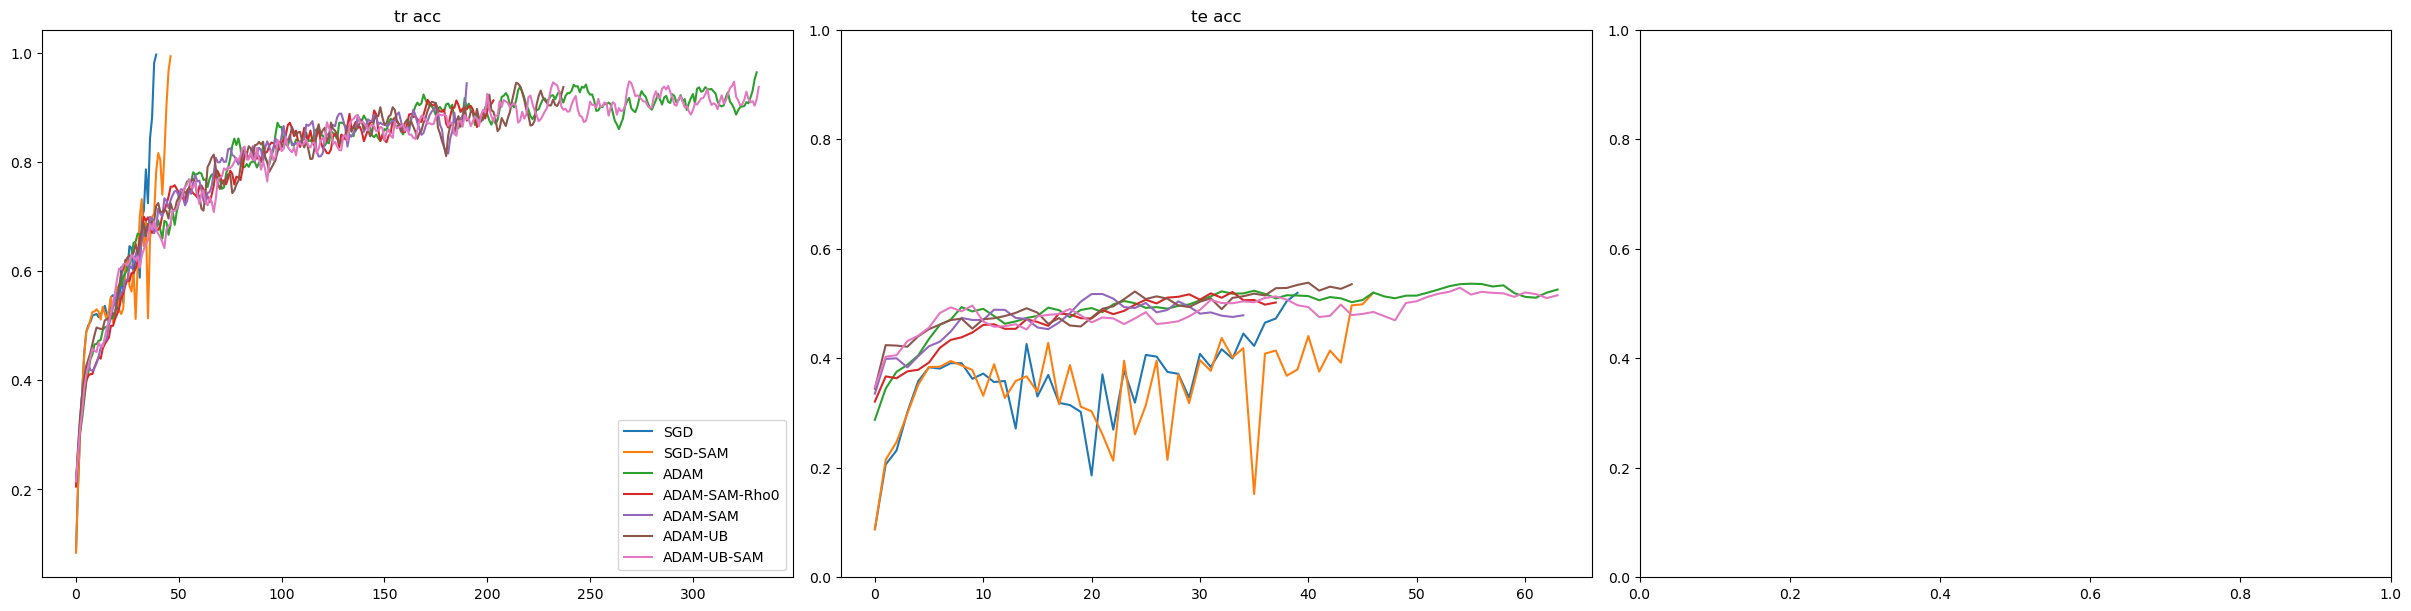

In [138]:
model_names = ['SGD', 'SGD-SAM', 'ADAM', 'ADAM-SAM-Rho0', 'ADAM-SAM', 'ADAM-UB', 'ADAM-UB-SAM', 'ADAM-UB-0.1']
fig, axs = plt.subplots(1, 3, figsize=(24, 6), layout='constrained')

for i in range(len(all_mh)):
# for i in range(2):
    gap = 1 if i < 2 else 5
    start = 0
    # start = 0 if i != 1 else 40
    
    axs[0].plot(utils.moving_average(np.array(all_mh[i]['train_accuracy'])[start::], w=gap), label=model_names[i], c=dark_colours(i))
    axs[1].plot(utils.moving_average(np.array(all_mh[i]['test_accuracy'])[start::gap], w=gap), c=dark_colours(i))
    # axs[2].plot(utils.moving_average(np.array(all_mh[i]['eigvals'])[::, 0], w=gap), c=dark_colours(i))
    print(model_names[i], all_mh[i]['test_accuracy'][-1], np.max(np.array(all_mh[i]['test_accuracy'])))

axs[0].legend()
axs[1].set_ylim(0, 1)
axs[0].set_title('tr acc')
axs[1].set_title('te acc')

plt.show()

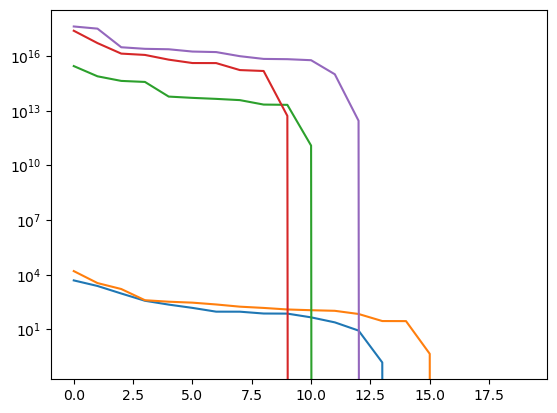

In [120]:
for i in range(5):
    plt.plot(np.array(all_mh[i]['eigvals'][-1][:]))
plt.yscale('log')